In [6]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math

In [7]:
from common import EEG_fif

In [8]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
#runs = [3,5,7]
subjects = [i for i in range(9,10)]
#subjects = [1]
#runs = [6,10,14]
print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
freq = (1., 45.)


raw=raw.notch_filter(50)

print("Filter done")
#raw=eeg.raw_ica()


/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S009/S009R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S009/S009R04.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S009/S009R07.fif) does not conform to MNE naming conventions. A

Raw done
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 sec)



/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S009/S009R08.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S009/S009R11.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:625: RuntimeWarning: This filename (S009/S009R12.fif) does not conform to MNE naming conventions. A

Filter done


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished


In [9]:

raw=raw.filter( 8,14, method='fir', verbose=20)


#raw=raw.filter(8., 14, fir_design='firwin', verbose=20)
#raw=raw.apply_hilbert()
#raw=eeg.filter(freq=freq)

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished


In [10]:
epochs=eeg.epochs_visu(raw,tmin=-2)

360 events found
Event IDs: [1 2 4]
Not setting metadata
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 1501 original time points ...
4 bad epochs dropped


/home/st122148/work/EEG-Motor-Imagery-Classification/common.py:655: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [11]:
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


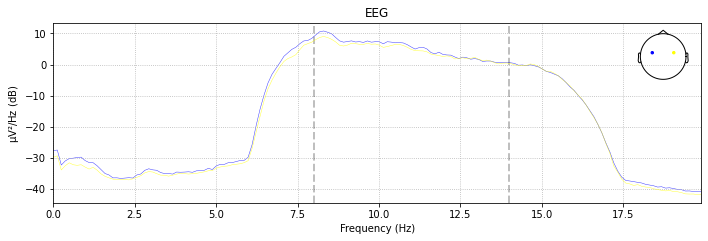

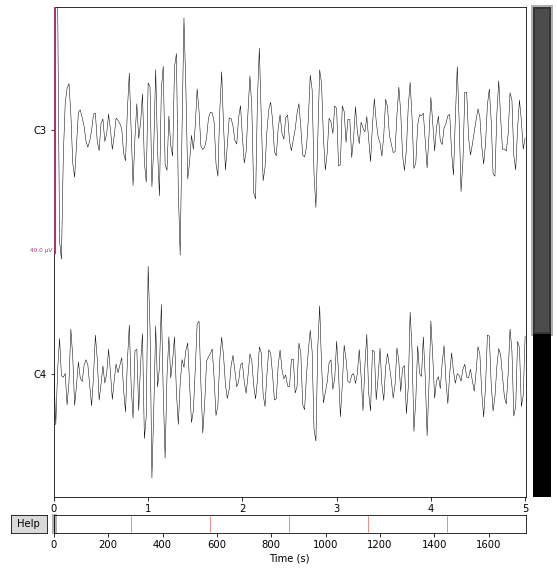

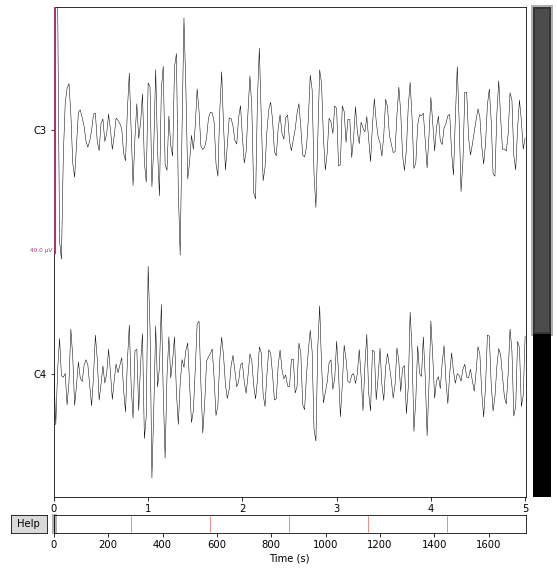

In [13]:
raw.plot_psd(fmax=20)
raw.plot(duration=5, n_channels=2)

In [14]:
epochs

Number of events,176
Events,1: 862: 903: 0
Time range,-2.000 – 4.000 sec
Baseline,-1.000 – 0.000 sec


In [15]:
epochs.event_id = {'Left': 1, 'Right': 2, '3': 3}
epochs.event_id

{'Left': 1, 'Right': 2, '3': 3}

In [16]:
l_vis_T1=epochs["Left"].average()
l_vis_T2=epochs["Right"].average()

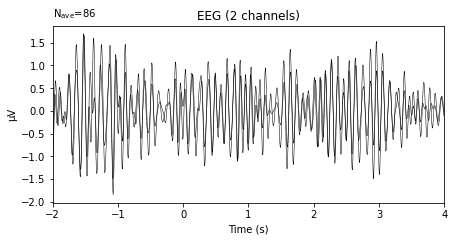

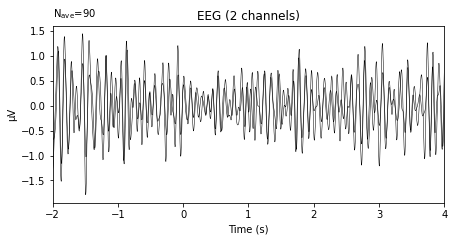

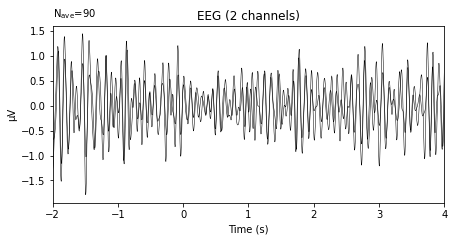

In [17]:
#l_vis_T1.plot(spatial_colors=True)
#l_vis_T2.plot(spatial_colors=True)


l_vis_T1.plot()
l_vis_T2.plot() 

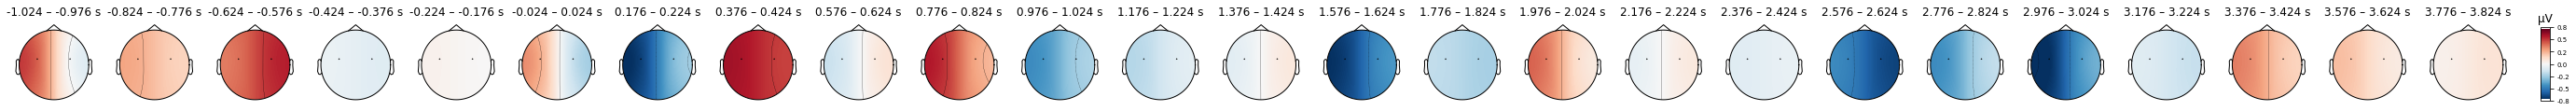

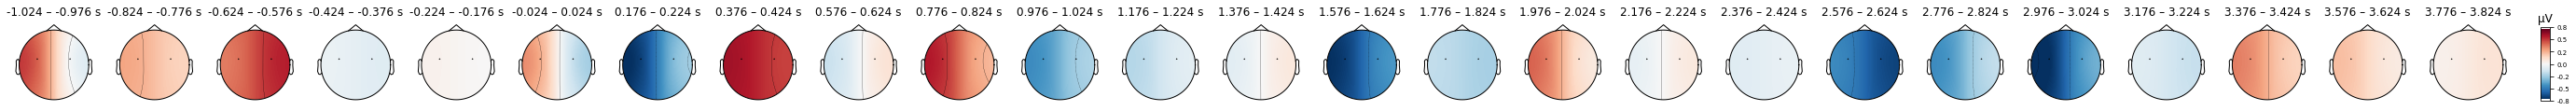

In [18]:
l_vis_T1.plot_topomap(times=list(np.arange(-1, 4, 0.20)), average=0.05, ch_type="eeg")

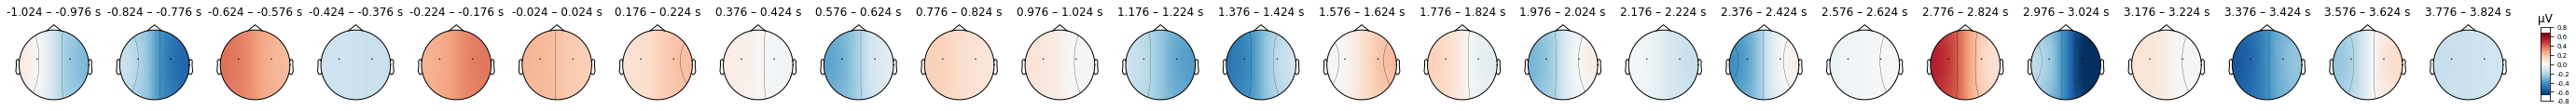

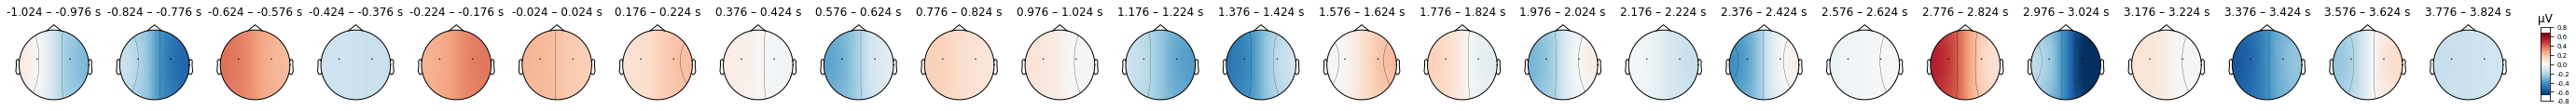

In [19]:
l_vis_T2.plot_topomap(times=list(np.arange(-1, 4, 0.20)), average=0.05, ch_type="eeg")

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test



#raw=eeg.filter(freq=freq)

In [21]:

freqs = np.arange(8, 14)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-2, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = -2, 4
event_ids = epochs.event_id

In [22]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s finished


In [23]:
df = tfr.to_data_frame(time_format=None)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

df.head()
df = tfr.to_data_frame(time_format=None, long_format=True)
df

Applying baseline correction (mode: percent)
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,freq,time,channel,ch_type,value
0,Right,2,8.0,-2.000,C3,eeg,-0.859472
1,Right,2,8.0,-2.000,C4,eeg,-0.970584
2,Right,2,8.0,-1.996,C3,eeg,-0.852451
3,Right,2,8.0,-1.996,C4,eeg,-0.971253
4,Right,2,8.0,-1.992,C3,eeg,-0.844989
...,...,...,...,...,...,...,...
3170107,Right,358,13.0,3.992,C4,eeg,-0.858682
3170108,Right,358,13.0,3.996,C3,eeg,-0.971210
3170109,Right,358,13.0,3.996,C4,eeg,-0.864184
3170110,Right,358,13.0,4.000,C3,eeg,-0.973115


In [24]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),
                                                     ordered=True)
df


Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "freq" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,freq,time,channel,ch_type,value,band
0,Right,2,8.0,-2.000,C3,eeg,-0.859472,alpha
1,Right,2,8.0,-2.000,C4,eeg,-0.970584,alpha
2,Right,2,8.0,-1.996,C3,eeg,-0.852451,alpha
3,Right,2,8.0,-1.996,C4,eeg,-0.971253,alpha
4,Right,2,8.0,-1.992,C3,eeg,-0.844989,alpha
...,...,...,...,...,...,...,...,...
3170107,Right,358,13.0,3.992,C4,eeg,-0.858682,alpha
3170108,Right,358,13.0,3.996,C3,eeg,-0.971210,alpha
3170109,Right,358,13.0,3.996,C4,eeg,-0.864184,alpha
3170110,Right,358,13.0,4.000,C3,eeg,-0.973115,alpha


In [27]:

g = sns.FacetGrid(df, row='band', col='condition')
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 2))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

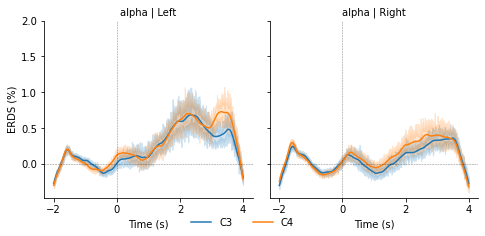

In [28]:
g.fig

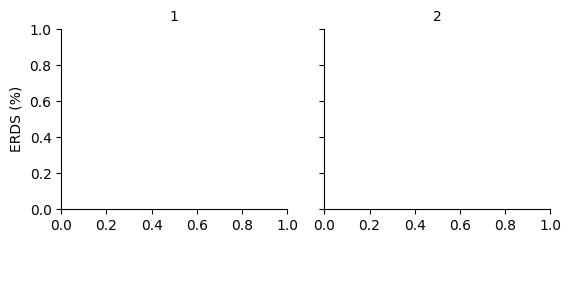

In [74]:
df_mean = (df.query('time > 1')
             .groupby(['condition', 'epoch', 'band', 'channel'])[['value']]
             .mean()
             .reset_index())

g = sns.FacetGrid(df_mean, col='condition', col_order=['1', '2'],
                  margin_titles=True)
g = (g.map(sns.violinplot, 'channel', 'value', 'band', n_boot=10,
           palette='deep', order=['C3',  'C4'],
           hue_order=freq_bands_of_interest,
           linewidth=0.5).add_legend(ncol=4, loc='lower center'))

g.map(plt.axhline, **axline_kw)
g.set_axis_labels("", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.3)
g.fig

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.663420
stat_fun(H1): min=-7.009684 max=5.705097
Running initial clustering …
Found 20 clusters


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished
100%|██████████| Permuting : 99/99 [00:01<00:00,   65.69it/s]

Step-down-in-jumps iteration #1 found 3 clusters to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:01<00:00,   73.65it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.663420
stat_fun(H1): min=-7.009684 max=5.705097
Running initial clustering …


Found 15 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   72.64it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


Using a threshold of 1.663420
stat_fun(H1): min=-7.315845 max=4.121918
Running initial clustering …
Found 20 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   88.20it/s]


Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:01<00:00,   69.96it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.663420
stat_fun(H1): min=-7.315845 max=4.121918
Running initial clustering …
Found 10 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   65.48it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.663420
stat_fun(H1): min=-7.009684 max=5.705097
Running initial clustering …
Found 20 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   72.03it/s]

Step-down-in-jumps iteration #1 found 3 clusters to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:01<00:00,   74.07it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.663420
stat_fun(H1): min=-7.009684 max=5.705097
Running initial clustering …
Found 15 clusters



100%|██████████| Permuting : 99/99 [00:01<00:00,   91.83it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


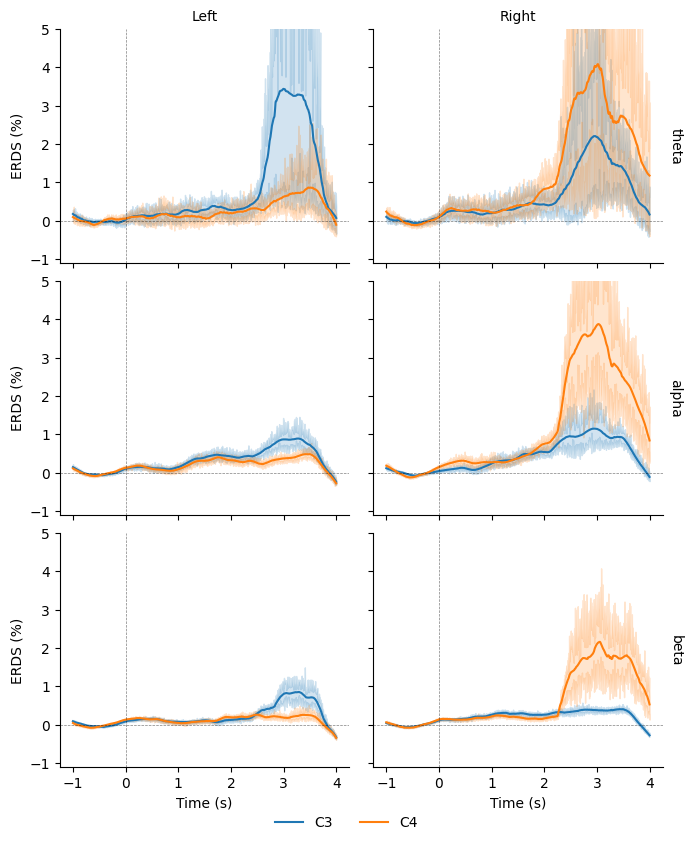

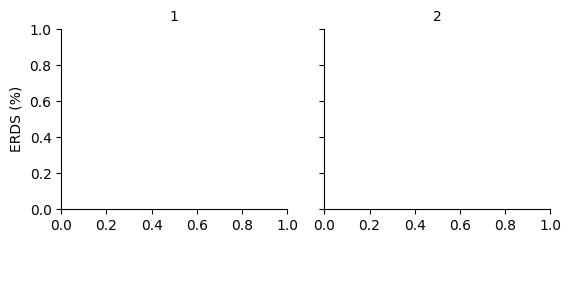

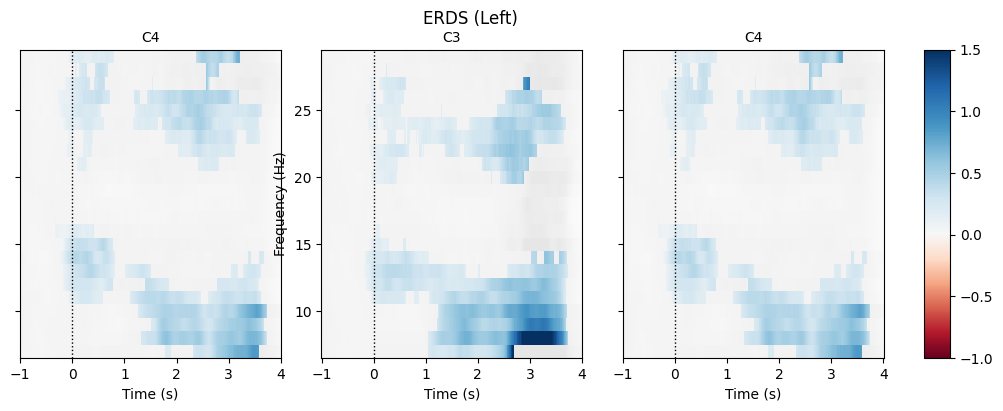

Using a threshold of 1.662155
stat_fun(H1): min=-5.108236 max=5.046256
Running initial clustering …
Found 15 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   74.84it/s]


Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:01<00:00,   70.16it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.662155
stat_fun(H1): min=-5.108236 max=5.046256
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   65.55it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:01<00:00,   75.54it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.662155
stat_fun(H1): min=-7.569923 max=4.101749
Running initial clustering …
Found 22 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  130.72it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:00<00:00,  104.96it/s]


Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:00<00:00,  132.12it/s]


Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.662155
stat_fun(H1): min=-7.569923 max=4.101749
Running initial clustering …
Found 15 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  116.98it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.662155
stat_fun(H1): min=-5.108236 max=5.046256
Running initial clustering …
Found 15 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   82.58it/s]


Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:01<00:00,   69.68it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.662155
stat_fun(H1): min=-5.108236 max=5.046256
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 99/99 [00:01<00:00,   68.46it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations



100%|██████████| Permuting : 99/99 [00:01<00:00,   66.73it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


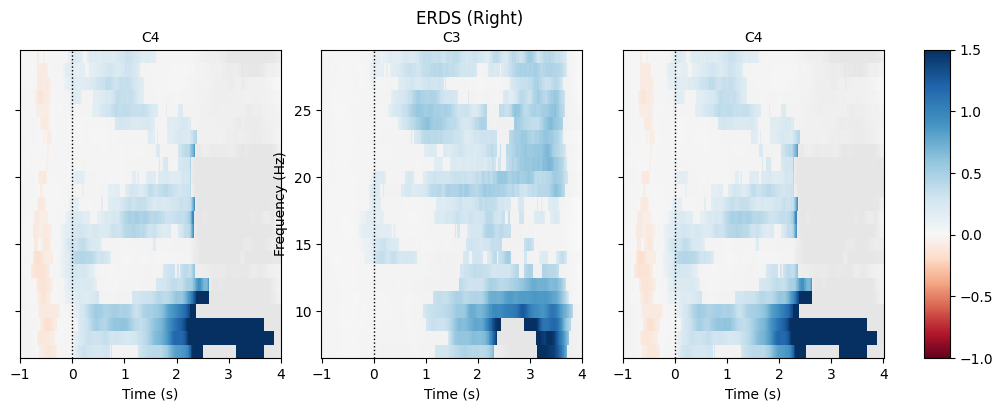

Using a threshold of nan


ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [67]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        ch = ch-1
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()